## Package installation

In [ ]:
# Installing packages using jupyter notebook
pip install plotly
pip install matplotlib
pip install scikit-learn
pip install --upgrade nbformat

## Import packages

In [1]:
# ETL
import os
import json
import random
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta, date

# Visualization
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# Clustering
from sklearn.cluster import KMeans


# Snowpark functions
import snowflake.snowpark.functions as F
from snowflake.snowpark.functions import lit
from snowflake.snowpark.session import Session
from snowflake.snowpark.version import VERSION

import warnings
warnings.filterwarnings('ignore')

## Create Session objects

In [170]:
# Create Snowflake Session object
connection_parameters = json.load(open('connection.json'))
conn = Session.builder.configs(connection_parameters).create()
conn.sql_simplifier_enabled = True
snowflake_environment = conn.sql('select current_user(), current_role(), current_database(), current_schema(), current_version(), current_warehouse()').collect()
snowpark_version = VERSION
# Current Environment Details
print('Database                    : {}'.format(snowflake_environment[0][2]))
print('Schema                      : {}'.format(snowflake_environment[0][3]))

Database                    : None
Schema                      : None


In [292]:
# Create Snowflake Session object
connection_parameters1 = json.load(open('connection_gdc.json'))
conn1 = Session.builder.configs(connection_parameters1).create()
conn1.sql_simplifier_enabled = True
snowflake_environment = conn1.sql('select current_user(), current_role(), current_database(), current_schema(), current_version(), current_warehouse()').collect()
snowpark_version = VERSION
# Current Environment Details
print('Database                    : {}'.format(snowflake_environment[0][2]))
print('Schema                      : {}'.format(snowflake_environment[0][3]))

Database                    : GDC_DEMO
Schema                      : LOYALTY_CLASSIFICATION


## Import data from snowflake

#### Dataset 1

In [3]:
dim_rb_acc = conn.table('RETAIL_BANKING_V1_1.PUBLIC."dim_rb_accounts"').to_pandas()
dim_rb_acc_ref = conn.table('RETAIL_BANKING_V1_1.PUBLIC."dim_rb_accounts_ref"').to_pandas()
dim_rb_cust = conn.table('RETAIL_BANKING_V1_1.PUBLIC."dim_rb_customers"').to_pandas()
dim_rb_date_ref = conn.table('RETAIL_BANKING_V1_1.PUBLIC."dim_rb_date_ref"').to_pandas()
fact_rb_checking = conn.table('RETAIL_BANKING_V1_1.PUBLIC."fact_rb_checking"').to_pandas()
fact_rb_credit_card = conn.table('RETAIL_BANKING_V1_1.PUBLIC."fact_rb_credit_card"').to_pandas()
fact_rb_credit_card2 = conn.table('RETAIL_BANKING_V1_1.PUBLIC."fact_rb_credit_card_2"').to_pandas()
fact_rb_loan = conn.table('RETAIL_BANKING_V1_1.PUBLIC."fact_rb_mortgage_loan"').to_pandas()
fact_rb_savings = conn.table('RETAIL_BANKING_V1_1.PUBLIC."fact_rb_savings"').to_pandas()

## Data Exploration

In [7]:
dim_rb_acc.head()

,account_id,customer_id,account_type,balance,opendate,closedate
0,0002-359992,359992,Savings,9943.438533,2019-06-01,2019-09-01
1,0002-359993,359993,Savings,7808.231375,2019-06-01,2019-09-01
2,0001-359994,359994,Checking,201.546609,2019-06-01,2019-09-01
3,0002-359994,359994,Savings,1228.761452,2019-06-01,2019-09-01
4,0002-359995,359995,Savings,15879.761228,2019-06-01,2019-09-01


In [24]:
print(f"Size of dim_rb_acc : {dim_rb_acc.shape}")
print(f"Number of unique Account ids: {len(dim_rb_acc.account_id.unique())}")
print(f"Number of unique Customer ids: {len(dim_rb_acc.customer_id.unique())}")
print(f"Number of unique Account types: {len(dim_rb_acc.account_type.unique())}")
print(f"Number of unique Account types: {dim_rb_acc.account_type.unique()}")
print(f"Number of unique open dates: {len(dim_rb_acc.opendate.unique())}")
print(f"Number of unique close dates: {len(dim_rb_acc.closedate.unique())}")


Size of dim_rb_acc : (390590, 6)
Number of unique Account ids: 390590
Number of unique Customer ids: 200000
Number of unique Account types: 6
Number of unique Account types: ['Savings' 'Checking' 'Credit Card (Advantage)' 'Mortgage Loan' 'IRA'
 'Credit Card (Platinum)']
Number of unique open dates: 1
Number of unique close dates: 1


In [44]:
ac_types = dict(dim_rb_acc.account_type.value_counts())
ac_types

{'Savings': 120030,
 'Checking': 107840,
 'Mortgage Loan': 56489,
 'IRA': 50988,
 'Credit Card (Advantage)': 38489,
 'Credit Card (Platinum)': 16754}

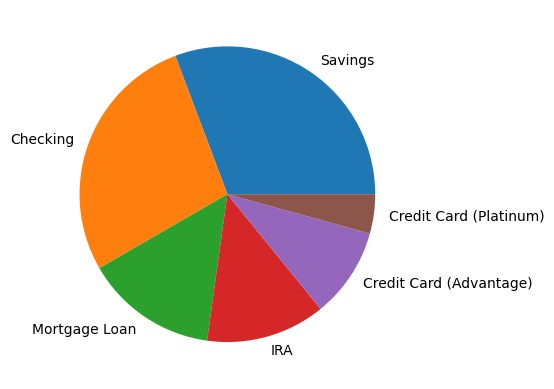

In [46]:
# Account type distribution
plt.pie(ac_types.values(),labels=ac_types.keys())
plt.show()

In [11]:
dim_rb_acc_ref.head()

,customer_id,checking,savings,creditcard,mortgageloan,checking_12_months,savings_12_months,creditcard_12_months,mortgageloan_12_months,ira,ira_12_months,credit_card_2,credit_card_2_12_months
0,359992,NaN,9943.44,NaN,NaN,NaN,8367.82,NaN,NaN,NaN,NaN,NaN,NaN
1,359993,NaN,7808.23,NaN,NaN,NaN,7617.62,NaN,NaN,NaN,NaN,NaN,NaN
2,359994,201.55,1228.76,NaN,NaN,286.18,1295.67,NaN,NaN,NaN,NaN,NaN,NaN
3,359995,NaN,15879.76,NaN,NaN,NaN,15007.71,NaN,NaN,NaN,NaN,NaN,NaN
4,359996,9453.13,1467.03,2433.33,NaN,9679.81,1322.87,2331.13,NaN,NaN,NaN,NaN,NaN


In [33]:
print(f"Size of dim_rb_acc_ref : {dim_rb_acc_ref.shape}")
print(f"Number of unique Customer ids: {len(dim_rb_acc_ref.customer_id.unique())}")

Size of dim_rb_acc_ref : (200000, 13)
Number of unique Customer ids: 200000


In [47]:
dim_rb_acc_ref.describe()

,customer_id,checking,savings,creditcard,mortgageloan,checking_12_months,savings_12_months,creditcard_12_months,mortgageloan_12_months,ira,ira_12_months,credit_card_2,credit_card_2_12_months
count,200000.000000,107840.000000,120030.000000,38489.000000,56489.000000,107840.000000,120030.000000,38489.000000,56489.000000,50988.000000,50988.000000,16754.000000,16754.000000
mean,459991.500000,8921.948451,9017.494116,3001.094204,1447.546078,8860.841607,8194.891569,3290.077582,1447.546078,91535.146509,86707.901658,4216.584185,4929.896874
std,57735.171256,7168.213267,11469.051835,916.121883,1004.970551,6602.627725,8619.041484,1303.296635,1004.970551,71137.780303,71002.174344,1026.622056,1848.293111
min,359992.000000,13.130000,14.020000,1033.330000,175.960000,15.900000,14.300000,622.060000,175.960000,6586.940000,1143.580000,1700.000000,1268.200000
25%,409991.750000,3502.065000,3289.647500,2433.330000,779.820000,3653.930000,3161.135000,2396.530000,779.820000,31419.120000,26655.235000,3400.000000,3656.570000
50%,459991.500000,7587.160000,6902.710000,3033.330000,1128.650000,7787.325000,6570.360000,3118.800000,1128.650000,71430.320000,66177.810000,4266.670000,4590.735000
75%,509991.250000,12925.145000,11909.880000,3600.000000,1731.580000,13000.807500,11074.592500,3951.500000,1731.580000,143859.690000,138696.962500,4800.000000,5782.210000
max,559991.000000,139913.000000,430739.610000,6400.000000,7049.460000,65345.120000,135282.460000,12257.400000,7049.460000,300013.350000,296906.380000,7400.000000,15624.000000


In [12]:
dim_rb_cust.head()

,customer_id,customer_name,gender,age,age_group,street_address,city,state,zipcode,county,latitude,longitude,region,opendate,closedate,income,state_full,product_count,credit_score
0,359992,Allison Bostian,Female,36,c) 35-44,111 Wayside Way,Baltimore,Maryland,21214,"Baltimore City, MD",0.0,0.0,East,None,None,65000,Maryland,1,744
1,359993,Alessandra Okajima,Female,33,b) 25-34,111 Wayside Way,San Antonio,Texas,78209,"Bexar County, TX",0.0,0.0,Southwest,None,None,71000,Texas,1,670
2,359994,Alvin Escuriex,Male,21,a) 18-24,111 Wayside Way,Columbus,Georgia,31906,"Muscogee County, GA",0.0,0.0,South,None,None,19000,Georgia,2,580
3,359995,Aniya Casanova,Female,76,f) 65+,111 Wayside Way,Camden,Tennessee,38320,"Carroll County, TN",0.0,0.0,South,None,None,25000,Tennessee,1,681
4,359996,Clarissa Pursel,Female,23,a) 18-24,111 Wayside Way,Bakersfield,California,93304,"Kern County, CA",0.0,0.0,West,None,None,26000,California,3,645


In [93]:
dim_rb_cust.columns

Index(['customer_id', 'customer_name', 'gender', 'age', 'age_group',
       'street_address', 'city', 'state', 'zipcode', 'county', 'latitude',
       'longitude', 'region', 'opendate', 'closedate', 'income', 'state_full',
       'product_count', 'credit_score'],
      dtype='object')

In [ ]:
#dropping 'street_address','latitude','longitude', 'opendate', 'closedate' columns 
dim_rb_cust = dim_rb_cust.drop(['street_address','latitude','longitude', 'opendate', 'closedate','age'],axis=1)
dim_rb_cust.head()

In [99]:
dim_rb_cust.head()

,customer_id,customer_name,gender,age_group,city,state,zipcode,county,region,income,state_full,product_count,credit_score
0,359992,Allison Bostian,Female,c) 35-44,Baltimore,Maryland,21214,"Baltimore City, MD",East,65000,Maryland,1,744
1,359993,Alessandra Okajima,Female,b) 25-34,San Antonio,Texas,78209,"Bexar County, TX",Southwest,71000,Texas,1,670
2,359994,Alvin Escuriex,Male,a) 18-24,Columbus,Georgia,31906,"Muscogee County, GA",South,19000,Georgia,2,580
3,359995,Aniya Casanova,Female,f) 65+,Camden,Tennessee,38320,"Carroll County, TN",South,25000,Tennessee,1,681
4,359996,Clarissa Pursel,Female,a) 18-24,Bakersfield,California,93304,"Kern County, CA",West,26000,California,3,645


In [229]:
# Data manipulation
# age_grp_list = dim_rb_cust.age_group.unique().tolist()
# region_list = dim_rb_cust.region.unique().tolist()
dim_rb_cust1 = dim_rb_cust.copy()
gender_list = dim_rb_cust.gender.unique().tolist()
np.random.seed(1) 
m = dim_rb_cust1['gender'].eq('male')
# dim_rb_cust1.loc[m, 'age_group'] = np.random.choice(age_grp_list, size=m.sum(),p=[0.05,0.025,0.025,0.05,0.05,0.8])
dim_rb_cust1.loc[m, 'gender'] = np.random.choice(gender_list, size=m.sum(), p =[0.15,0.85])
# dim_rb_cust1.loc[m, 'age_group'] = np.random.choice(age_grp_list, size=m.sum(),p=[0.05,0.025,0.025,0.05,0.05,0.8])

{'Male': 129474, 'Female': 70526}


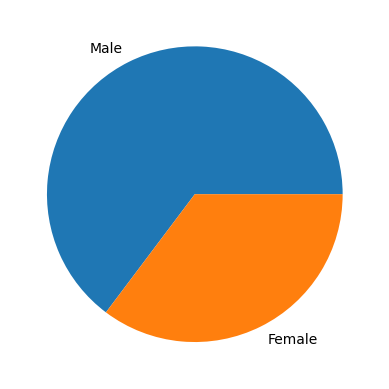

In [231]:
gender = dict(dim_rb_cust1.gender.value_counts())
print(gender)
plt.pie(gender.values(),labels=gender.keys())
plt.show()

{'a) 18-24': 51404, 'b) 25-34': 42728, 'e) 55-64': 31650, 'f) 65+': 29026, 'c) 35-44': 25293, 'd) 45-54': 19899}


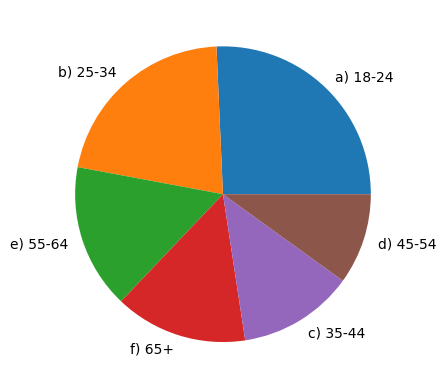

In [208]:
# age = dict(dim_rb_cust1.age.value_counts())
# print(age)
age_grp = dict(dim_rb_cust1.age_group.value_counts())
print(age_grp)
plt.pie(age_grp.values(),labels=age_grp.keys())
plt.show()

{'Midwest': 53544, 'West': 50724, 'South': 37128, 'East': 34413, 'Southwest': 24191}


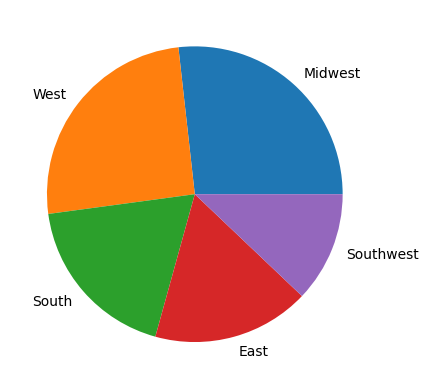

In [224]:
region = dict(dim_rb_cust1.region.value_counts())
print(region)
plt.pie(region.values(),labels=region.keys())
plt.show()

In [232]:
dim_rb_cust1.head()

,customer_id,customer_name,gender,age_group,city,state,zipcode,county,region,income,state_full,product_count,credit_score
0,359992,Allison Bostian,Female,c) 35-44,Baltimore,Maryland,21214,"Baltimore City, MD",Southwest,65000,Maryland,1,744
1,359993,Alessandra Okajima,Male,a) 18-24,San Antonio,Texas,78209,"Bexar County, TX",Southwest,71000,Texas,1,670
2,359994,Alvin Escuriex,Male,a) 18-24,Columbus,Georgia,31906,"Muscogee County, GA",South,19000,Georgia,2,580
3,359995,Aniya Casanova,Female,f) 65+,Camden,Tennessee,38320,"Carroll County, TN",East,25000,Tennessee,1,681
4,359996,Clarissa Pursel,Female,a) 18-24,Bakersfield,California,93304,"Kern County, CA",West,26000,California,3,645


### Data cleaning and Transformation

In [248]:
east = dim_rb_cust[['city','county','state']][dim_rb_cust.region == 'East']
east_concat = (east.city+":"+east.county+":"+east.state).to_list()
Midwest = dim_rb_cust[['city','county','state']][dim_rb_cust.region == 'Midwest']
Midwest_concat = (Midwest.city+":"+Midwest.county+":"+Midwest.state).to_list()
West = dim_rb_cust[['city','county','state']][dim_rb_cust.region == 'West']
West_concat = (West.city+":"+West.county+":"+West.state).to_list()
South = dim_rb_cust[['city','county','state']][dim_rb_cust.region == 'South']
South_concat = (South.city+":"+South.county+":"+South.state).to_list()
Southwest = dim_rb_cust[['city','county','state']][dim_rb_cust.region == 'Southwest']
Southwest_concat = (Southwest.city+":"+Southwest.county+":"+Southwest.state).to_list()

In [262]:
np.random.seed(1) 
m = dim_rb_cust1['region'].eq('Southwest')
# dim_rb_cust1.loc[m, 'age_group'] = np.random.choice(age_grp_list, size=m.sum(),p=[0.05,0.025,0.025,0.05,0.05,0.8])
dim_rb_cust1.loc[m, 'concat'] = np.random.choice(Southwest_concat, size=m.sum())
dim_rb_cust1[['city','county','state']] = dim_rb_cust1['concat'].str.split(":",expand=True)
dim_rb_cust1.head(2)

,customer_id,customer_name,gender,age_group,city,state,zipcode,county,region,income,state_full,product_count,credit_score,concat
0,359992,Allison Bostian,Female,c) 35-44,Baltimore,Maryland,21214,"Baltimore City, MD",Southwest,65000,Maryland,1,744,"Kerrville:Kerr County, TX:Texas"
1,359993,Alessandra Okajima,Male,a) 18-24,San Antonio,Texas,78209,"Bexar County, TX",Southwest,71000,Texas,1,670,"Midland:Midland County, TX:Texas"
2,359994,Alvin Escuriex,Male,a) 18-24,Columbus,Georgia,31906,"Muscogee County, GA",South,19000,Georgia,2,580,"Charlotte:Mecklenburg County, NC:North Carolina"
3,359995,Aniya Casanova,Female,f) 65+,Camden,Tennessee,38320,"Carroll County, TN",East,25000,Tennessee,1,681,"South Berwick:York County, ME:Maine"
4,359996,Clarissa Pursel,Female,a) 18-24,Bakersfield,California,93304,"Kern County, CA",West,26000,California,3,645,"Patterson:Stanislaus County, CA:California"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,559987,Zainab Wenthold,Male,b) 25-34,Jefferson City,Missouri,65109,"Cole County, MO",Midwest,57000,Missouri,2,708,"Cleveland:Cuyahoga County, OH:Ohio"
199996,559988,Delilah Derman,Female,e) 55-64,York,Maine,03909,"York County, ME",East,32000,Maine,1,762,"Barre:Worcester County, MA:Massachusetts"
199997,559989,Lacey Kostiv,Female,e) 55-64,Lexington,Kentucky,40511,"Scott County, KY",South,43000,Kentucky,1,696,"Jenkins:Pike County, KY:Kentucky"
199998,559990,Jordyn Tebay,Female,c) 35-44,Coachella,California,92236,"Riverside County, CA",West,41000,California,3,586,"Galt:San Joaquin County, CA:California"


In [267]:
#save results to snowflake
conn1.createDataFrame(dim_rb_cust1.drop(['state_full','concat'],axis=1)).write.save_as_table(table_name='dim_rb_customers',mode='overwrite')

In [34]:
print(f"Size of dim_rb_cust : {dim_rb_cust.shape}")
print(f"Number of unique Customer ids: {len(dim_rb_cust.customer_id.unique())}")

Size of dim_rb_cust : (200000, 19)
Number of unique Customer ids: 200000


In [14]:
fact_rb_checking.head()

,record_id,customer_id,account_id,account_type,balance,record_date
0,1146881,537354,0001-537354,Checking,1728.36,2019-05-01
1,1146882,537354,0001-537354,Checking,1663.37,2019-06-01
2,1146883,537354,0001-537354,Checking,1584.15,2019-07-01
3,1146884,537354,0001-537354,Checking,1445.18,2019-08-01
4,1146885,537354,0001-537354,Checking,1303.92,2019-09-01


In [35]:
print(f"Size of fact_rb_checking : {fact_rb_checking.shape}")
print(f"Number of account types : {len(fact_rb_checking.account_type.unique())}")
print(f"Number of record dates : {len(fact_rb_checking.record_date.unique())}")
print(f"Number of customers with this account type : {len(fact_rb_checking.customer_id.unique())}")

Size of fact_rb_checking : (1294080, 6)
Number of unique Customer ids: 107840
Number of account types : 1
Number of record dates : 12
Number of customers with this account type : 107840


In [15]:
fact_rb_credit_card.head()

,record_id,customer_id,account_id,account_type,balance,paid,record_date
0,1,359996,0003-359996,Credit Card (Advantage),2331.13,2331.13,2019-01-01
1,2,359996,0003-359996,Credit Card (Advantage),2581.76,2581.76,2019-02-01
2,3,359996,0003-359996,Credit Card (Advantage),2710.73,2710.73,2019-03-01
3,4,359996,0003-359996,Credit Card (Advantage),2141.33,2141.33,2019-04-01
4,5,359996,0003-359996,Credit Card (Advantage),2520.93,2520.93,2019-05-01


In [36]:
print(f"Size of fact_rb_credit_card : {fact_rb_credit_card.shape}")
print(f"Number of account types : {len(fact_rb_credit_card.account_type.unique())}")
print(f"Number of record dates : {len(fact_rb_credit_card.record_date.unique())}")
print(f"Number of customers with this account type : {len(fact_rb_credit_card.customer_id.unique())}")

Size of fact_rb_credit_card : (461868, 7)
Number of account types : 1
Number of record dates : 12
Number of customers with this account type : 38489


In [16]:
fact_rb_loan.head()

,record_id,customer_id,account_id,account_type,balance,paid,record_date
0,1,359999,0005-359999,Mortgage Loan,987.17,987.17,2019-01-01
1,2,359999,0005-359999,Mortgage Loan,987.17,987.17,2019-02-01
2,3,359999,0005-359999,Mortgage Loan,987.17,987.17,2019-03-01
3,4,359999,0005-359999,Mortgage Loan,987.17,987.17,2019-04-01
4,5,359999,0005-359999,Mortgage Loan,987.17,987.17,2019-05-01


In [37]:
print(f"Size of fact_rb_loan : {fact_rb_loan.shape}")
print(f"Number of account types : {len(fact_rb_loan.account_type.unique())}")
print(f"Number of record dates : {len(fact_rb_loan.record_date.unique())}")
print(f"Number of customers with this account type : {len(fact_rb_loan.customer_id.unique())}")

Size of fact_rb_loan : (677868, 7)
Number of account types : 1
Number of record dates : 12
Number of customers with this account type : 56489


In [17]:
fact_rb_savings.head()

,record_id,customer_id,account_id,account_type,balance,record_date
0,1146881,519182,0002-519182,Savings,5525.26,2019-05-01
1,1146882,519182,0002-519182,Savings,5708.36,2019-06-01
2,1146883,519182,0002-519182,Savings,5897.54,2019-07-01
3,1146884,519182,0002-519182,Savings,6134.47,2019-08-01
4,1146885,519182,0002-519182,Savings,6195.97,2019-09-01


In [38]:
print(f"Size of fact_rb_savings : {fact_rb_savings.shape}")
print(f"Number of account types : {len(fact_rb_savings.account_type.unique())}")
print(f"Number of record dates : {len(fact_rb_savings.record_date.unique())}")
print(f"Number of customers with this account type : {len(fact_rb_savings.customer_id.unique())}")

Size of fact_rb_savings : (1440360, 6)
Number of account types : 1
Number of record dates : 12
Number of customers with this account type : 120030


#### Dataset 2

In [54]:
bank_txns = pd.read_csv('bank_transactions.csv')
bank_txns.columns

Index(['TransactionID', 'CustomerID', 'CustomerDOB', 'CustGender',
       'CustLocation', 'CustAccountBalance', 'TransactionDate',
       'TransactionTime', 'TransactionAmount (INR)'],
      dtype='object')

In [55]:
bank_txns.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


In [108]:
bank_txns.columns

Index(['TransactionID', 'CustomerID', 'CustomerDOB', 'CustGender',
       'CustLocation', 'CustAccountBalance', 'TransactionDate',
       'TransactionTime', 'TransactionAmount (INR)'],
      dtype='object')

In [109]:
bank_txns1 = bank_txns.drop(['CustomerDOB', 'CustGender','CustLocation'],axis=1)
bank_txns1.head()

,TransactionID,CustomerID,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,17819.05,2/8/16,143207,25.0
1,T2,C2142763,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,17874.44,2/8/16,142712,459.0
3,T4,C5342380,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,6714.43,2/8/16,181156,1762.5


In [113]:
# Data manipulation using sampling
# Sampling 200000 customers
np.random.seed(1)
cust_sample = np.random.choice(bank_txns.CustomerID.unique(), size = 200000,replace=False)
cust_sample

array(['C8323065', 'C6565643', 'C4838524', ..., 'C8830791', 'C1115047',
       'C1060032'], dtype=object)

In [ ]:
# Data manipulation
# mapping customers to get transaction data 
mapping_data = pd.DataFrame()
mapping_data['id1'] = dim_rb_cust.customer_id.unique().tolist()
mapping_data['id2'] = cust_sample.tolist()
mapping_data

In [164]:
bank_txns2 = bank_txns1[bank_txns1['CustomerID'].isin(mapping_data.id2.values.tolist())]
bank_txns2['CustomerID'] = bank_txns2['CustomerID'].map(mapping_data.set_index('id2')['id1'])
bank_txns2['TransactionDate'] = pd.to_datetime(bank_txns2['TransactionDate'], format='%d/%m/%y').dt.strftime('%Y-%m-%d')
bank_txns2['TransactionDate'] = bank_txns2['TransactionDate'].apply(lambda x:pd.to_datetime(x)+pd.DateOffset(years= 7))
bank_txns2['TransactionAmount'] = bank_txns2['TransactionAmount (INR)']
bank_txns3 = bank_txns2.drop(['TransactionAmount (INR)','CustAccountBalance'],axis=1)
bank_txns3.head(2)

/var/folders/dm/cg0pgfr90sj6zv84qw8pj85w0000gp/T/ipykernel_58796/429638434.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bank_txns2['TransactionAmount'] = bank_txns2['TransactionAmount (INR)']


,TransactionID,CustomerID,TransactionDate,TransactionTime,TransactionAmount
0,T1,386320,2023-08-02,143207,25.00
3,T4,380319,2023-08-02,142714,2060.00
8,T9,409858,2023-08-02,192825,833.00
9,T10,397898,2023-08-02,192446,289.11
10,T11,397806,2023-08-02,204133,259.00
...,...,...,...,...,...
1048542,T1048543,490937,2023-09-18,182855,800.00
1048544,T1048545,446168,2023-09-18,182015,400.00
1048554,T1048555,486425,2023-09-18,185332,500.00
1048556,T1048557,497874,2023-09-18,184932,2000.00


In [173]:
#save results to snowflake
conn1.createDataFrame(bank_txns3).write.save_as_table(table_name='Transactions',mode='overwrite')
conn1.createDataFrame(dim_rb_acc.drop(['opendate','closedate'],axis=1)).write.save_as_table(table_name='dim_rb_accounts',mode='overwrite')
conn1.createDataFrame(dim_rb_acc_ref).write.save_as_table(table_name='dim_rb_accounts_ref',mode='overwrite')

In [181]:
fact_rb_credit_card2 = conn.table('RETAIL_BANKING_V1_1.PUBLIC."fact_rb_credit_card_2"').to_pandas()
fact_rb_credit_card2.head()

,record_id,customer_id,account_id,account_type,balance,paid,record_date
0,1,360030,0004-360030,Credit Card (Platinum),5841.73,5841.73,2019-01-01
1,2,360030,0004-360030,Credit Card (Platinum),6601.46,6601.46,2019-02-01
2,3,360030,0004-360030,Credit Card (Platinum),4727.80,4727.80,2019-03-01
3,4,360030,0004-360030,Credit Card (Platinum),5451.60,5451.60,2019-04-01
4,5,360030,0004-360030,Credit Card (Platinum),5251.40,5251.40,2019-05-01


In [176]:
fact_rb_checking['record_date'] = fact_rb_checking['record_date'].apply(lambda x:pd.to_datetime(x)+pd.DateOffset(years= 4))
fact_rb_credit_card['record_date'] = fact_rb_credit_card['record_date'].apply(lambda x:pd.to_datetime(x)+pd.DateOffset(years= 4))
fact_rb_credit_card2['record_date'] = fact_rb_credit_card2['record_date'].apply(lambda x:pd.to_datetime(x)+pd.DateOffset(years= 4))
fact_rb_loan['record_date'] = fact_rb_loan['record_date'].apply(lambda x:pd.to_datetime(x)+pd.DateOffset(years= 4))
fact_rb_savings['record_date'] = fact_rb_savings['record_date'].apply(lambda x:pd.to_datetime(x)+pd.DateOffset(years= 4))

In [183]:
fact_rb_credit_card2.head()

,record_id,customer_id,account_id,account_type,balance,paid,record_date
0,1,360030,0004-360030,Credit Card (Platinum),5841.73,5841.73,2023-01-01
1,2,360030,0004-360030,Credit Card (Platinum),6601.46,6601.46,2023-02-01
2,3,360030,0004-360030,Credit Card (Platinum),4727.80,4727.80,2023-03-01
3,4,360030,0004-360030,Credit Card (Platinum),5451.60,5451.60,2023-04-01
4,5,360030,0004-360030,Credit Card (Platinum),5251.40,5251.40,2023-05-01


In [184]:
conn1.createDataFrame(fact_rb_checking).write.save_as_table(table_name='fact_rb_checking',mode='overwrite')
conn1.createDataFrame(fact_rb_credit_card).write.save_as_table(table_name='fact_rb_credit_card',mode='overwrite')
conn1.createDataFrame(fact_rb_credit_card2).write.save_as_table(table_name='fact_rb_credit_card_2',mode='overwrite')
conn1.createDataFrame(fact_rb_loan).write.save_as_table(table_name='fact_rb_mortgage_loan',mode='overwrite')
conn1.createDataFrame(fact_rb_savings).write.save_as_table(table_name='fact_rb_savings',mode='overwrite')

## Customer Segmentation

In [279]:
bank_txns3.reset_index(inplace=True)
bank_txns3.head()

,index,TransactionID,CustomerID,TransactionDate,TransactionTime,TransactionAmount
0,0,T1,386320,2023-08-02,143207,25.00
1,3,T4,380319,2023-08-02,142714,2060.00
2,8,T9,409858,2023-08-02,192825,833.00
3,9,T10,397898,2023-08-02,192446,289.11
4,10,T11,397806,2023-08-02,204133,259.00


In [280]:
dim_rb_cust1.head()

,customer_id,customer_name,gender,age_group,city,state,zipcode,county,region,income,state_full,product_count,credit_score,concat
0,359992,Allison Bostian,Female,c) 35-44,Kerrville,Texas,21214,"Kerr County, TX",Southwest,65000,Maryland,1,744,"Kerrville:Kerr County, TX:Texas"
1,359993,Alessandra Okajima,Male,a) 18-24,Midland,Texas,78209,"Midland County, TX",Southwest,71000,Texas,1,670,"Midland:Midland County, TX:Texas"
2,359994,Alvin Escuriex,Male,a) 18-24,Charlotte,North Carolina,31906,"Mecklenburg County, NC",South,19000,Georgia,2,580,"Charlotte:Mecklenburg County, NC:North Carolina"
3,359995,Aniya Casanova,Female,f) 65+,South Berwick,Maine,38320,"York County, ME",East,25000,Tennessee,1,681,"South Berwick:York County, ME:Maine"
4,359996,Clarissa Pursel,Female,a) 18-24,Patterson,California,93304,"Stanislaus County, CA",West,26000,California,3,645,"Patterson:Stanislaus County, CA:California"


In [281]:
bank_txns3.head()

,index,TransactionID,CustomerID,TransactionDate,TransactionTime,TransactionAmount
0,0,T1,386320,2023-08-02,143207,25.00
1,3,T4,380319,2023-08-02,142714,2060.00
2,8,T9,409858,2023-08-02,192825,833.00
3,9,T10,397898,2023-08-02,192446,289.11
4,10,T11,397806,2023-08-02,204133,259.00


In [289]:
merged_data = pd.merge(dim_rb_cust1.drop(['state_full','concat'],axis=1),bank_txns3.drop(['index'],axis=1),left_on='customer_id',right_on='CustomerID')
merged_data.head()

,customer_id,customer_name,gender,age_group,city,state,zipcode,county,region,income,product_count,credit_score,TransactionID,CustomerID,TransactionDate,TransactionTime,TransactionAmount
0,359992,Allison Bostian,Female,c) 35-44,Kerrville,Texas,21214,"Kerr County, TX",Southwest,65000,1,744,T821581,359992,2023-09-04,172811,381.0
1,359993,Alessandra Okajima,Male,a) 18-24,Midland,Texas,78209,"Midland County, TX",Southwest,71000,1,670,T918141,359993,2023-09-12,201203,550.0
2,359994,Alvin Escuriex,Male,a) 18-24,Charlotte,North Carolina,31906,"Mecklenburg County, NC",South,19000,2,580,T18713,359994,2023-09-26,192137,201.0
3,359994,Alvin Escuriex,Male,a) 18-24,Charlotte,North Carolina,31906,"Mecklenburg County, NC",South,19000,2,580,T382890,359994,2023-08-13,180255,20.0
4,359994,Alvin Escuriex,Male,a) 18-24,Charlotte,North Carolina,31906,"Mecklenburg County, NC",South,19000,2,580,T605851,359994,2023-08-26,191314,300.0


In [293]:
conn1.createDataFrame(merged_data).write.save_as_table(table_name='cust_txns_data_merged',mode='overwrite')

In [294]:
pd.DataFrame({
    'unique_count':merged_data.nunique(),
    'rows_count':merged_data.count()
})

,unique_count,rows_count
customer_id,200000,237012
customer_name,199847,237012
gender,2,237012
age_group,6,237012
city,9804,237012
state,49,237012
zipcode,22132,237012
county,2776,237012
region,5,237012
income,317,237012


#### K-Means Clustering

In [301]:
# Define K-means model
kmeans_model = KMeans(init='k-means++',  max_iter=400, random_state=42)

In [299]:
print(merged_data.columns)
merged_data.head()

Index(['customer_id', 'customer_name', 'gender', 'age_group', 'city', 'state',
       'zipcode', 'county', 'region', 'income', 'product_count',
       'credit_score', 'TransactionID', 'CustomerID', 'TransactionDate',
       'TransactionTime', 'TransactionAmount'],
      dtype='object')


,customer_id,customer_name,gender,age_group,city,state,zipcode,county,region,income,product_count,credit_score,TransactionID,CustomerID,TransactionDate,TransactionTime,TransactionAmount
0,359992,Allison Bostian,Female,c) 35-44,Kerrville,Texas,21214,"Kerr County, TX",Southwest,65000,1,744,T821581,359992,2023-09-04,172811,381.0
1,359993,Alessandra Okajima,Male,a) 18-24,Midland,Texas,78209,"Midland County, TX",Southwest,71000,1,670,T918141,359993,2023-09-12,201203,550.0
2,359994,Alvin Escuriex,Male,a) 18-24,Charlotte,North Carolina,31906,"Mecklenburg County, NC",South,19000,2,580,T18713,359994,2023-09-26,192137,201.0
3,359994,Alvin Escuriex,Male,a) 18-24,Charlotte,North Carolina,31906,"Mecklenburg County, NC",South,19000,2,580,T382890,359994,2023-08-13,180255,20.0
4,359994,Alvin Escuriex,Male,a) 18-24,Charlotte,North Carolina,31906,"Mecklenburg County, NC",South,19000,2,580,T605851,359994,2023-08-26,191314,300.0


In [302]:
# Define K-means model
kmeans_model = KMeans(init='k-means++',  max_iter=400, random_state=42)
# Train the model
kmeans_model.fit(merged_data[['income','credit_score','TransactionAmount']])

/Users/cheppali.soundarya/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(max_iter=400, random_state=42)

#### Elbow method to identify ideal number of clusters for this data

In [ ]:
data = merged_data[['income','credit_score','TransactionAmount']]
inertias = []

for i in range(1,13):
    kmeans = KMeans(n_clusters = i,init='k-means++',max_iter=400,random_state=42)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,13), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [ ]:
# Re-Train K means model with k=5
kmeans_model_new = KMeans(n_clusters = 6,init='k-means++',max_iter=400,random_state=42)
kmeans_model_new.fit_predict(data)

In [308]:
# Create data arrays
cluster_centers = kmeans_model_new.cluster_centers_
data = np.expm1(cluster_centers)
points = np.append(data, cluster_centers, axis=1)

# Add "clusters" to customers data
points = np.append(points, [[0], [1], [2], [3], [4], [5]], axis=1)
merged_data['clusters'] = kmeans_model_new.labels_
merged_data.head(2)

,customer_id,customer_name,gender,age_group,city,state,zipcode,county,region,income,product_count,credit_score,TransactionID,CustomerID,TransactionDate,TransactionTime,TransactionAmount,clusters
0,359992,Allison Bostian,Female,c) 35-44,Kerrville,Texas,21214,"Kerr County, TX",Southwest,65000,1,744,T821581,359992,2023-09-04,172811,381.00,4
1,359993,Alessandra Okajima,Male,a) 18-24,Midland,Texas,78209,"Midland County, TX",Southwest,71000,1,670,T918141,359993,2023-09-12,201203,550.00,4
2,359994,Alvin Escuriex,Male,a) 18-24,Charlotte,North Carolina,31906,"Mecklenburg County, NC",South,19000,2,580,T18713,359994,2023-09-26,192137,201.00,3
3,359994,Alvin Escuriex,Male,a) 18-24,Charlotte,North Carolina,31906,"Mecklenburg County, NC",South,19000,2,580,T382890,359994,2023-08-13,180255,20.00,3
4,359994,Alvin Escuriex,Male,a) 18-24,Charlotte,North Carolina,31906,"Mecklenburg County, NC",South,19000,2,580,T605851,359994,2023-08-26,191314,300.00,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237007,559988,Delilah Derman,Female,e) 55-64,Barre,Massachusetts,03909,"Worcester County, MA",East,32000,1,762,T263941,559988,2023-08-12,201423,210.00,3
237008,559989,Lacey Kostiv,Female,e) 55-64,Jenkins,Kentucky,40511,"Pike County, KY",South,43000,1,696,T357153,559989,2023-08-14,161307,686.00,0
237009,559989,Lacey Kostiv,Female,e) 55-64,Jenkins,Kentucky,40511,"Pike County, KY",South,43000,1,696,T360913,559989,2023-08-14,172631,500.00,0
237010,559990,Jordyn Tebay,Female,c) 35-44,Galt,California,92236,"San Joaquin County, CA",West,41000,3,586,T970042,559990,2023-09-10,145113,168.67,0


In [319]:
merged_data.to_csv('data_with_clusters.csv',index=False)

## RFM Analysis

In [3]:
df = pd.read_csv('/Users/mohammed.arshad/Downloads/data_with_clusters.csv')
df.head(2)

,customer_id,customer_name,gender,age_group,city,state,zipcode,county,region,income,product_count,credit_score,TransactionID,CustomerID,TransactionDate,TransactionTime,TransactionAmount,clusters
0,359992,Allison Bostian,Female,c) 35-44,Kerrville,Texas,21214,"Kerr County, TX",Southwest,65000,1,744,T821581,359992,2023-09-04,172811,381.0,4
1,359993,Alessandra Okajima,Male,a) 18-24,Midland,Texas,78209,"Midland County, TX",Southwest,71000,1,670,T918141,359993,2023-09-12,201203,550.0,4
2,359994,Alvin Escuriex,Male,a) 18-24,Charlotte,North Carolina,31906,"Mecklenburg County, NC",South,19000,2,580,T18713,359994,2023-09-26,192137,201.0,3
3,359994,Alvin Escuriex,Male,a) 18-24,Charlotte,North Carolina,31906,"Mecklenburg County, NC",South,19000,2,580,T382890,359994,2023-08-13,180255,20.0,3
4,359994,Alvin Escuriex,Male,a) 18-24,Charlotte,North Carolina,31906,"Mecklenburg County, NC",South,19000,2,580,T605851,359994,2023-08-26,191314,300.0,3


In [4]:
# There are few rows with time in SS format instead of HHMMSS format to handle this correctly adding 00 to MMSS and 0000 to SS values 
def modify_time(value):
    value_str = str(value).zfill(6)  # Ensure the value is at least 6 digits long
    return f"{value_str[:2]}00{value_str[2:]}" if len(value_str) == 4 else f"0000{value_str}" if len(value_str) == 2 else value_str



# Apply the function to modify the 'TransactionTime' column
df['TransactionTime'] = df['TransactionTime'].apply(lambda x: modify_time(x))

# dropping duplicate CustomerID column
df.drop(('CustomerID'),axis=1, inplace= True)

#removing serial letters in age_group column  
df['age_group'] = df['age_group'].str.replace('[a-zA-Z)]', '', regex=True)

# converting date time to standard format
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])
df['TransactionTime'] = pd.to_datetime(df['TransactionTime'], format='%H%M%S', errors='coerce')

# Combine date and time into a new datetime column
df['TransactionDateTime'] = df['TransactionDate'] + pd.to_timedelta(df['TransactionTime'].dt.strftime('%H:%M:%S'))

df.head(2)

,customer_id,customer_name,gender,age_group,city,state,zipcode,county,region,income,product_count,credit_score,TransactionID,TransactionDate,TransactionTime,TransactionAmount,clusters,TransactionDateTime
0,359992,Allison Bostian,Female,35-44,Kerrville,Texas,21214,"Kerr County, TX",Southwest,65000,1,744,T821581,2023-09-04,1900-01-01 17:28:11,381.00,4,2023-09-04 17:28:11
1,359993,Alessandra Okajima,Male,18-24,Midland,Texas,78209,"Midland County, TX",Southwest,71000,1,670,T918141,2023-09-12,1900-01-01 20:12:03,550.00,4,2023-09-12 20:12:03
2,359994,Alvin Escuriex,Male,18-24,Charlotte,North Carolina,31906,"Mecklenburg County, NC",South,19000,2,580,T18713,2023-09-26,1900-01-01 19:21:37,201.00,3,2023-09-26 19:21:37
3,359994,Alvin Escuriex,Male,18-24,Charlotte,North Carolina,31906,"Mecklenburg County, NC",South,19000,2,580,T382890,2023-08-13,1900-01-01 18:02:55,20.00,3,2023-08-13 18:02:55
4,359994,Alvin Escuriex,Male,18-24,Charlotte,North Carolina,31906,"Mecklenburg County, NC",South,19000,2,580,T605851,2023-08-26,1900-01-01 19:13:14,300.00,3,2023-08-26 19:13:14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237007,559988,Delilah Derman,Female,55-64,Barre,Massachusetts,3909,"Worcester County, MA",East,32000,1,762,T263941,2023-08-12,1900-01-01 20:14:23,210.00,3,2023-08-12 20:14:23
237008,559989,Lacey Kostiv,Female,55-64,Jenkins,Kentucky,40511,"Pike County, KY",South,43000,1,696,T357153,2023-08-14,1900-01-01 16:13:07,686.00,0,2023-08-14 16:13:07
237009,559989,Lacey Kostiv,Female,55-64,Jenkins,Kentucky,40511,"Pike County, KY",South,43000,1,696,T360913,2023-08-14,1900-01-01 17:26:31,500.00,0,2023-08-14 17:26:31
237010,559990,Jordyn Tebay,Female,35-44,Galt,California,92236,"San Joaquin County, CA",West,41000,3,586,T970042,2023-09-10,1900-01-01 14:51:13,168.67,0,2023-09-10 14:51:13


#### Recency (R): Calculate the recency of each customer based on the last transaction date

In [6]:
df_recency = df.groupby(by='customer_id', 
                        as_index=False)['TransactionDateTime'].max()
df_recency.columns = ['customer_id', 'LastPurchaseDate']
recent_date = df_recency['LastPurchaseDate'].max()
df_recency['Recency'] = df_recency['LastPurchaseDate'].apply(
    lambda x: (recent_date - x).days)
df_recency.head(2)

,customer_id,LastPurchaseDate,Recency
0,359992,2023-09-04 17:28:11,47
1,359993,2023-09-12 20:12:03,39
2,359994,2023-09-26 19:21:37,25
3,359995,2023-09-15 16:39:34,36
4,359996,2023-08-17 08:53:47,65
...,...,...,...
199995,559987,2023-08-13 17:44:21,69
199996,559988,2023-08-12 20:14:23,70
199997,559989,2023-08-14 17:26:31,68
199998,559990,2023-09-10 14:51:13,41


#### Frequency (F): Calculate the frequency of transactions for each customer


In [7]:
frequency_df = df.drop_duplicates().groupby(
    by=['customer_id'], as_index=False)['TransactionDateTime'].count()
frequency_df.columns = ['customer_id', 'Frequency']
frequency_df.head(2)

,customer_id,Frequency
0,359992,1
1,359993,1
2,359994,4
3,359995,1
4,359996,2
...,...,...
199995,559987,2
199996,559988,1
199997,559989,2
199998,559990,1


#### Monetary (M): Calculate the total monetary value of transactions for each customer.

In [8]:
df['Total'] = df['TransactionAmount']
monetary_df = df.groupby(by='customer_id', as_index=False)['Total'].sum()
monetary_df.columns = ['customer_id', 'Monetary']
monetary_df.head(2)

,customer_id,Monetary
0,359992,381.00
1,359993,550.00
2,359994,870.00
3,359995,3350.00
4,359996,1650.00
...,...,...
199995,559987,150.00
199996,559988,210.00
199997,559989,1186.00
199998,559990,168.67


#### Create RFM Segments

In [9]:
# Merging all three columns in one dataframe
rf_df = df_recency.merge(frequency_df, on='customer_id')
rfm_df = rf_df.merge(monetary_df, on='customer_id').drop(
    columns='LastPurchaseDate')
rfm_df.head(2)

,customer_id,Recency,Frequency,Monetary
0,359992,47,1,381.00
1,359993,39,1,550.00
2,359994,25,4,870.00
3,359995,36,1,3350.00
4,359996,65,2,1650.00
...,...,...,...,...
199995,559987,69,2,150.00
199996,559988,70,1,210.00
199997,559989,68,2,1186.00
199998,559990,41,1,168.67


In [10]:
# Ranking Customer’s based upon their recency, frequency, and monetary score
rfm_df['R_rank'] = rfm_df['Recency'].rank(ascending=False)
rfm_df['F_rank'] = rfm_df['Frequency'].rank(ascending=True)
rfm_df['M_rank'] = rfm_df['Monetary'].rank(ascending=True)
 
# normalizing the rank of the customers
rfm_df['R_rank_norm'] = (rfm_df['R_rank']/rfm_df['R_rank'].max())*100
rfm_df['F_rank_norm'] = (rfm_df['F_rank']/rfm_df['F_rank'].max())*100
rfm_df['M_rank_norm'] = (rfm_df['F_rank']/rfm_df['M_rank'].max())*100
 
rfm_df.drop(columns=['R_rank', 'F_rank', 'M_rank'], inplace=True)
 
rfm_df.head(2)

,customer_id,Recency,Frequency,Monetary,R_rank_norm,F_rank_norm,M_rank_norm
0,359992,47,1,381.00,66.903654,41.896209,41.89600
1,359993,39,1,550.00,85.850137,41.896209,41.89600
2,359994,25,4,870.00,97.937757,99.885749,99.88525
3,359995,36,1,3350.00,92.416647,41.896209,41.89600
4,359996,65,2,1650.00,31.901888,90.863454,90.86300
...,...,...,...,...,...,...,...
199995,559987,69,2,150.00,23.510122,90.863454,90.86300
199996,559988,70,1,210.00,21.337402,41.896209,41.89600
199997,559989,68,2,1186.00,25.866220,90.863454,90.86300
199998,559990,41,1,168.67,80.594573,41.896209,41.89600


In [11]:
# Calculating RFM score
# RFM score is calculated based upon recency, frequency, monetary value normalize ranks. Based upon this score we divide our customers.
# Here we rate them on a scale of 5. Formula used for calculating rfm score is : 0.15*Recency score + 0.28*Frequency score + 0.57 *Monetary score
rfm_df['RFM_Score'] = 0.15*rfm_df['R_rank_norm']+0.28 * \
    rfm_df['F_rank_norm']+0.57*rfm_df['M_rank_norm']
rfm_df['RFM_Score'] *= 0.05
rfm_df = rfm_df.round(2)
rfm_df.head()


,customer_id,Recency,Frequency,Monetary,R_rank_norm,F_rank_norm,M_rank_norm,RFM_Score
0,359992,47,1,381.0,66.90,41.90,41.90,2.28
1,359993,39,1,550.0,85.85,41.90,41.90,2.42
2,359994,25,4,870.0,97.94,99.89,99.89,4.98
3,359995,36,1,3350.0,92.42,41.90,41.90,2.47
4,359996,65,2,1650.0,31.90,90.86,90.86,4.10


In [13]:
rfm_df["Customer_segment"] = np.where(rfm_df['RFM_Score'] >
                                      4.5, "Big Spenders", 
                                      (np.where(
                                        rfm_df['RFM_Score'] > 4,
                                        "Active Regulars",
                                        (np.where(
    rfm_df['RFM_Score'] > 2,
                             "Valued Customers",
                             np.where(rfm_df['RFM_Score'] > 1.6, 
                            'Engaged Explorers', 'Lost Customers'))))))
rfm_df.head()

,customer_id,Recency,Frequency,Monetary,R_rank_norm,F_rank_norm,M_rank_norm,RFM_Score,Customer_segment
0,359992,47,1,381.00,66.90,41.90,41.90,2.28,Valued Customers
1,359993,39,1,550.00,85.85,41.90,41.90,2.42,Valued Customers
2,359994,25,4,870.00,97.94,99.89,99.89,4.98,Big Spenders
3,359995,36,1,3350.00,92.42,41.90,41.90,2.47,Valued Customers
4,359996,65,2,1650.00,31.90,90.86,90.86,4.10,Active Regulars
...,...,...,...,...,...,...,...,...,...
199995,559987,69,2,150.00,23.51,90.86,90.86,4.04,Active Regulars
199996,559988,70,1,210.00,21.34,41.90,41.90,1.94,Engaged Explorers
199997,559989,68,2,1186.00,25.87,90.86,90.86,4.06,Active Regulars
199998,559990,41,1,168.67,80.59,41.90,41.90,2.39,Valued Customers


In [14]:
rfm_df['Customer_segment'].value_counts()

Valued Customers     113856
Engaged Explorers     55019
Active Regulars       20453
Big Spenders          10672
Name: Customer_segment, dtype: int64

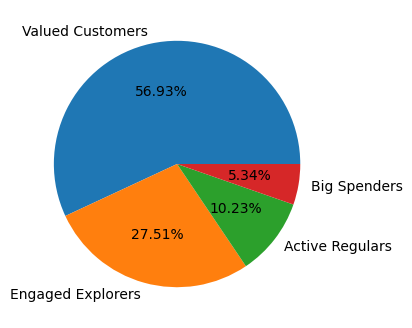

In [15]:
plt.figure(figsize=(6, 4)) 
plt.pie(rfm_df.Customer_segment.value_counts(),
        labels=rfm_df.Customer_segment.value_counts().index,
        autopct='%.2f%%')
plt.show()

In [ ]:
rfm_customer_segmentation = df.merge(rfm_df, on='customer_id')
rfm_customer_segmentation['TransactionDate'] = rfm_customer_segmentation['TransactionDate'].dt.date
rfm_customer_segmentation.head(2)

In [26]:
#save results to snowflake
conn1.createDataFrame(rfm_customer_segmentation).write.mode('overwrite').save_as_table('RFM_based_customer_segmentation')

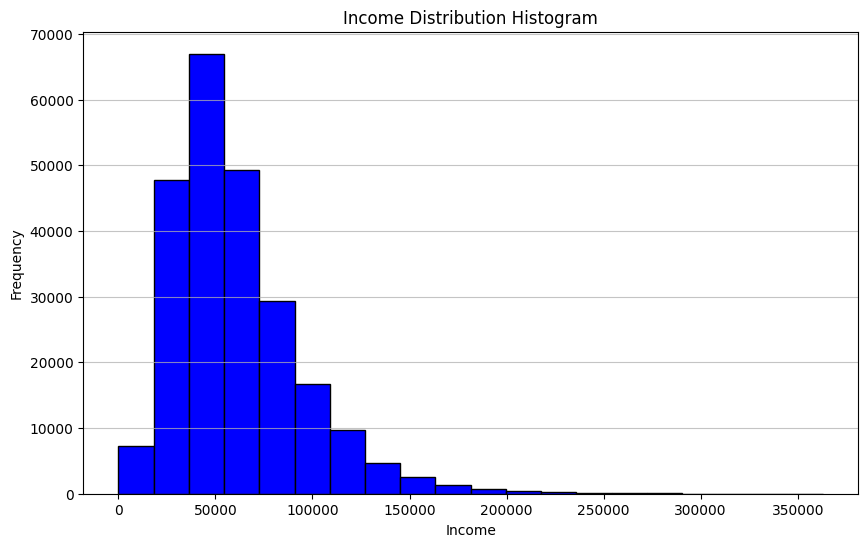

In [21]:
# Assuming you have the data in a pandas DataFrame named 'rfm_customer_segmentation'
# If not, you can load the data from your source using appropriate code

# Extract the 'income' column
income_data = rfm_customer_segmentation['income']

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(income_data, bins=20, color='blue', edgecolor='black')  # You can adjust the number of bins as needed
plt.title('Income Distribution Histogram')
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

# Show the plot
plt.show()


In [ ]:
# Assuming df is your DataFrame
df_sorted = rfm_customer_segmentation.sort_values(by='TransactionDateTime', ascending=False)

# Assuming df is your DataFrame
df_filtered = rfm_df[rfm_df['TransactionDateTime'] != '2023-10-21']

# Display the DataFrame without rows where TransactionDateTime is '2023-10-21'
print(df_filtered[['customer_id', 'customer_name', 'TransactionDateTime', 'Total', 'Recency', 'Frequency', 'Monetary', 'RFM_Score', 'Customer_segment']].head())
